In [1]:
### importing necessary packages 

import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D, Concatenate, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
#from google.colab import drive
import seaborn as sns
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import time

In [2]:
os.chdir('D:/case study 2')

In [3]:
### reference - https://www.tensorflow.org/api_docs/python/tf/io/read_file

def load_image(image, col_mask, tab_mask):
    '''this function will resize the images to 1024*1024
       and normalize every pixel by dividing by 255'''
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [1024,1024])
    image = tf.cast(image, tf.float32) / 255.0
    col_mask = tf.io.read_file(col_mask)
    col_mask = tf.image.decode_jpeg(col_mask, channels=1)
    col_mask = tf.image.resize(col_mask, [1024,1024])
    col_mask = tf.cast(col_mask, tf.float32) / 255.0 
    tab_mask = tf.io.read_file(tab_mask)
    tab_mask = tf.image.decode_jpeg(tab_mask, channels = 1)
    tab_mask = tf.image.resize(tab_mask, [1024,1024])
    tab_mask = tf.cast(tab_mask, tf.float32) / 255.0
    return image, {"column_mask" : col_mask, "table_mask" : tab_mask}

In [4]:
def precision(mask, predicted_mask):
    m = tf.keras.metrics.Precision()
    m.update_state(mask, predicted_mask)
    return m.result().numpy()

In [5]:
def recall(mask, predicted_mask):
    m = tf.keras.metrics.Recall()
    m.update_state(mask, predicted_mask)
    return m.result().numpy()

In [6]:
pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"

In [7]:
def image_to_text(img_name):
    text = pytesseract.image_to_string(Image.open(img_name))
    return text

In [8]:
def create_masks(col_mask, tab_mask):
    col_mask = tf.argmax(col_mask, axis = -1)
    col_mask = col_mask[..., np.newaxis]
    tab_mask = tf.argmax(tab_mask, axis = -1)
    tab_mask = tab_mask[..., np.newaxis]
    
    return col_mask[0], tab_mask[0]

### Loading our model

In [9]:
interpreter = tf.lite.Interpreter("vgg_compressed.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
def function_one(image_path):
    '''this function will take an image and predict its target and column mask
       and extract text from it
    '''
    image = cv2.imread(image_path)
    img = tf.image.resize(image, [1024,1024])
    img = tf.cast(img, tf.float32) / 255.0
    img = img[np.newaxis , :,:,:]
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    col_mask = interpreter.get_tensor(output_details[0]['index'])
    tab_mask = interpreter.get_tensor(output_details[1]['index'])
    col_mask , tab_mask = create_masks(col_mask, tab_mask)
    img = tf.squeeze(img)
    im = tf.keras.preprocessing.image.array_to_img(img)
    im.save("org_image.bmp")
    img = Image.open("org_image.bmp")
    col_mask = tf.keras.preprocessing.image.array_to_img(col_mask)
    tab_mask = tf.keras.preprocessing.image.array_to_img(tab_mask)
    img.putalpha(tab_mask)
    img.save("output_alpha.png")
    plt.figure(figsize = (40,20))
    plt.subplot(121)
    plt.imshow(Image.open("org_image.bmp"))
    plt.title("Original Image", fontsize = 30)
    plt.subplot(122)
    plt.imshow(Image.open("output_alpha.png"))
    plt.title("Cropped Image", fontsize = 30)
    plt.show()
    text = (image_to_text("output_alpha.png"))
    return text

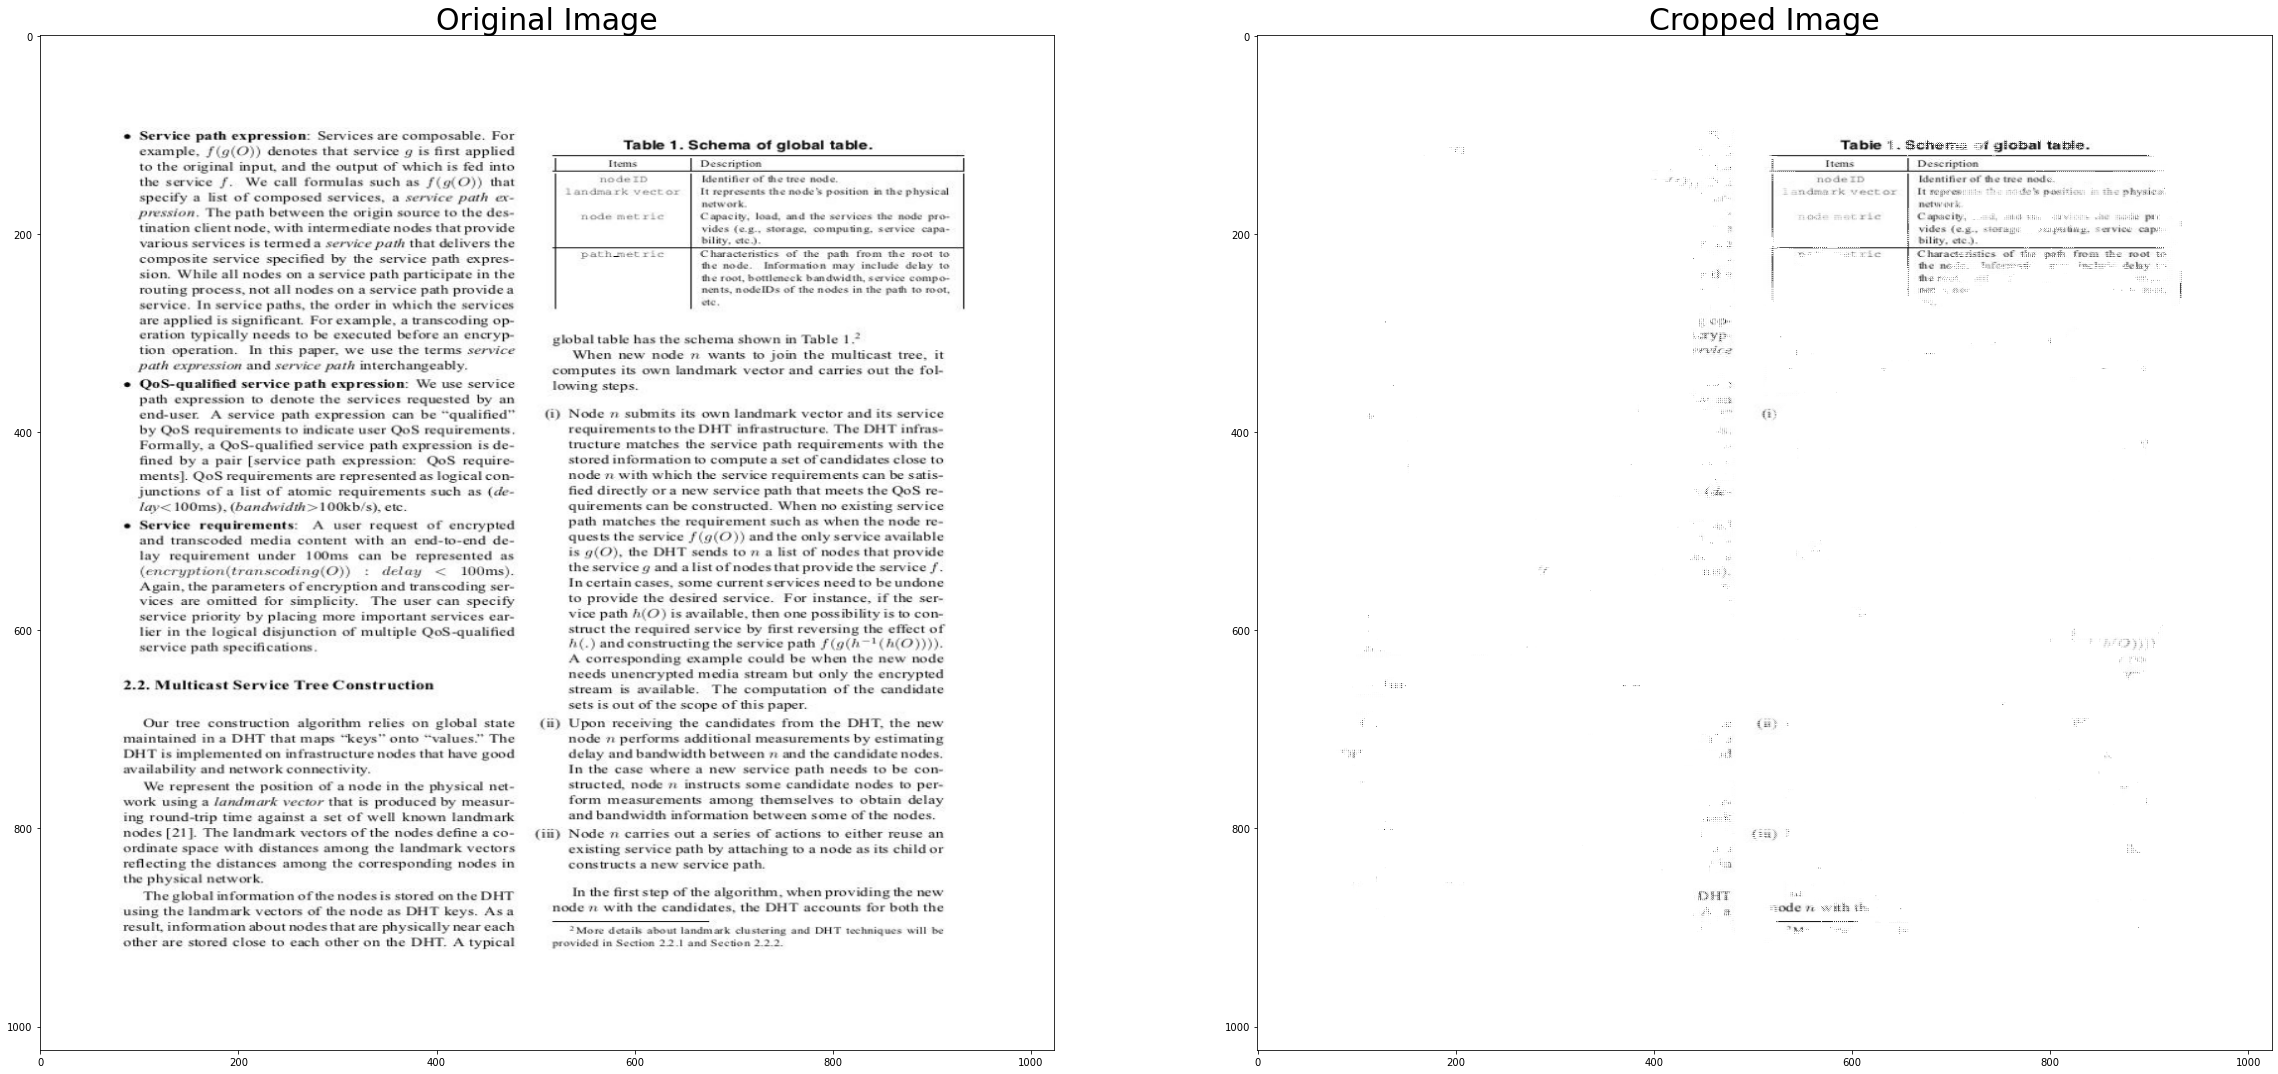

****************************************************************************************************


 

Wf gtobal table.
Tame Description

     

 

L
ientifior of tho tee node
Tesegees: 08 pec: physio
ode aserte | Capeiy, oi, onnen ay io pe
2 vides (eg. stom’ >upubug. rerviow cap:
Z bility. ete.

 

   

 

ere Wp Troms Ge woot te
Festi eta

8
w
aa

4

aay

DHT .

ae rode re with tf:

 

Time taken to predict 179.28051924705505


In [23]:
start = time.time()
image_path = "D:/Applied AI/Case study 2/images/10.1.1.1.2030_4.jpeg"
text = function_one(image_path)
print ("*"*100)
print ('\n')
print (text)
end = time.time()
print ("Time taken to predict {}".format(end - start))

In [24]:
def function_two(image_path, col_mask, tab_mask):
    '''this function will take an image , its column and table mask and predict its target and column mask
       and extract text from it and will also print the precision and recall.
    '''
    image, mask = load_image(image_path, col_mask, tab_mask)
    img = image[np.newaxis , :,:,:]
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    col_mask = interpreter.get_tensor(output_details[0]['index'])
    tab_mask = interpreter.get_tensor(output_details[1]['index'])
    col_mask , tab_mask = create_masks(col_mask, tab_mask)
    actual_col_mask = mask['column_mask']
    actual_tab_mask = mask['table_mask']
    p = precision(actual_col_mask, col_mask)
    print ("precision for col mask is {}".format(p))
    p = precision(actual_tab_mask, tab_mask)
    print ("precision for tab mask is {}".format(p))
    r = recall(actual_col_mask, col_mask)
    print ("recall for col mask is {}".format(r))
    r = recall(actual_tab_mask, tab_mask)
    print ("recall for tab mask is {}".format(r))
    img = tf.squeeze(img)
    im = tf.keras.preprocessing.image.array_to_img(img)
    im.save("org_image.bmp")
    img = Image.open("org_image.bmp")
    col_mask = tf.keras.preprocessing.image.array_to_img(col_mask)
    tab_mask = tf.keras.preprocessing.image.array_to_img(tab_mask)
    actual_tab_mask = tf.keras.preprocessing.image.array_to_img(actual_tab_mask)
    img.putalpha(tab_mask)
    img.save("output_alpha_pred.png")
    img = Image.open("org_image.bmp")
    img.putalpha(actual_tab_mask)
    img.save("output_alpha_act.png")
    plt.figure(figsize = (40,20))
    plt.subplot(131)
    plt.imshow(Image.open("org_image.bmp"))
    plt.title("Original Image", fontsize = 30)
    plt.subplot(132)
    plt.imshow(Image.open("output_alpha_act.png"))
    plt.title("True Crop", fontsize = 30)
    plt.subplot(133)
    plt.imshow(Image.open("output_alpha_pred.png"))
    plt.title("Predicted Crop", fontsize = 30)
    plt.show()
    text = (image_to_text("output_alpha_pred.png"))
    return text

precision for col mask is 0.4812677502632141
precision for tab mask is 0.4089812636375427
recall for col mask is 0.5983802676200867
recall for tab mask is 0.9118684530258179


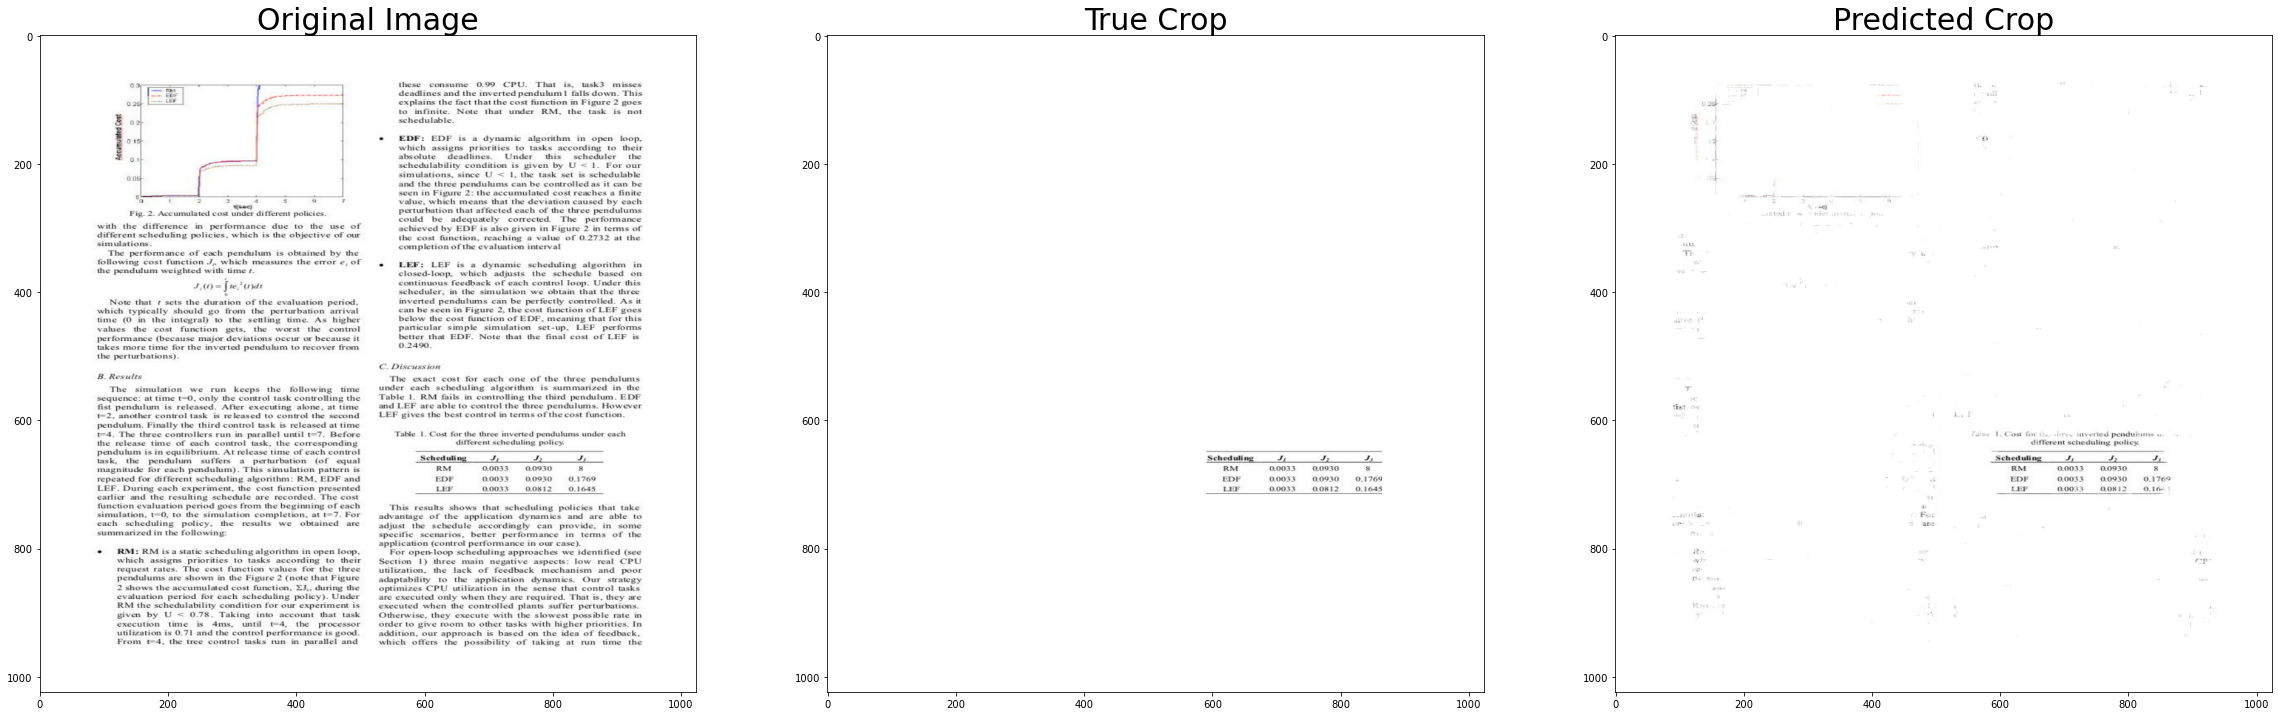

****************************************************************************************************


 

 

 

Fy

 

different scheduli

 

d pend
ing polices,

 

 

Sacto
<a

RM

EDF

 

0.0033
0.0033
0.0033

0.0930
0.08.

 

0.1769
6

 

 

Time taken to predict 176.32143878936768


In [27]:
start = time.time()
image_path = "D:/Applied AI/Case study 2/images/10.1.1.1.2006_3.jpeg"
col_mask = "D:/Applied AI/Case study 2/output/10.1.1.1.2006_3/column_mask.jpeg"
tab_mask = "D:/Applied AI/Case study 2/output/10.1.1.1.2006_3/table_mask.jpeg"
text = function_two(image_path, col_mask, tab_mask)
print ("*"*100)
print ('\n')
print (text)
end = time.time()
print ("Time taken to predict {}".format(end - start))